<a href="https://colab.research.google.com/github/bibake/Disaster_Tweet_Classification/blob/master/20_04_NLP_DisasterTweets_BU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import os
import pickle
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.exceptions import FitFailedWarning
warnings.filterwarnings("ignore", category = DeprecationWarning)
warnings.filterwarnings('ignore', category = FitFailedWarning)
warnings.filterwarnings('ignore', category = UserWarning)

<br>
<br>

# 1. Introduction

This notebook depicts a comprehensive programming solution to solve the Kaggle text classification challenge described [here](https://www.kaggle.com/c/nlp-getting-started/overview).

<br>

The task is a supervised binary text classification task of tweets from Twitter. The tweets are classified as either related to a **real disaster** or **not**. The purpose of the task is to establish an algorithm that can automatically and accurately determine if a tweet is referring to a real disaster or not. The applications for this are wide-ranging. Among the main uses is as an **emergency response support tool**. 

<br>

At a high level, this notebook achieves the following:

- Understand data
- Prepare data
- Train classification algorithms
- Make predictions on unseen data

<br>

The notebook is organized in the following sections:<br /><font size="2"> _**Note**: these sections can be navigated using the table of contents found in the left side-bar._

1. Introduction
2. Load and Explore Data
3. Baseline Models
4. Further Cleaning and Modelling
5. Deep Learning
6. Conclusion

The main focus of this notebook is on non-deep learning techniques. Thus, only the last portion of the notebook is dedicated to deep learning.

<br>
<br>

# 2. Load and Explore Data

## Load and Basic Overview

Algorithms are triained using a labelled dataset provided on Kaggle ([here](https://www.kaggle.com/c/nlp-getting-started/data) and [here](https://gist.githubusercontent.com/bibake/f484cab46630d36bf05faf78fb65a358/raw/95a256cfef101a317115f6d5f0ff5f91ee8e9fc6/train.csv)). Predictions are made on the unlabelled test set ([here](https://www.kaggle.com/c/nlp-getting-started/data) and [here](https://gist.githubusercontent.com/bibake/f484cab46630d36bf05faf78fb65a358/raw/95a256cfef101a317115f6d5f0ff5f91ee8e9fc6/test.csv)).

Here we load the two datasets, as well as a submission file.

In [0]:
train = pd.read_csv('https://gist.githubusercontent.com/bibake/f484cab46630d36bf05faf78fb65a358/raw/95a256cfef101a317115f6d5f0ff5f91ee8e9fc6/train.csv')
test = pd.read_csv('https://gist.githubusercontent.com/bibake/f484cab46630d36bf05faf78fb65a358/raw/95a256cfef101a317115f6d5f0ff5f91ee8e9fc6/test.csv')
submission = pd.read_csv('https://gist.githubusercontent.com/bibake/f484cab46630d36bf05faf78fb65a358/raw/d89ae3903e8b24869a5fb58b1cdb79ad5c31f19d/sample_submission.csv')

The datasets, the first 5 lines of which can be seen below, contain the following columns:

- **id** - a unique identifier for each tweet
- **text** - the text of the tweet
- **location** - the location the tweet was sent from (may be blank)
- **keyword** - a particular keyword from the tweet (may be blank)
- **target** - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

In [0]:
pd.set_option('display.max_colwidth', None)
display(train.head(), test.head(), submission.head())

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


### Shape

In [0]:
print('There are {} rows and {} columns in train'.format(train.shape[0], train.shape[1]))
print('There are {} rows and {} columns in train'.format(test.shape[0], test.shape[1]))

There are 7613 rows and 5 columns in train
There are 3263 rows and 4 columns in train


### Data-types and NULLs

In [0]:
print(train.info())
print('\n', train.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None

 id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


We see from the output above that there are two numeric columns and three categorical. Of the five, two have missing values, keyword and location.

### Class balance

In [0]:
train.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

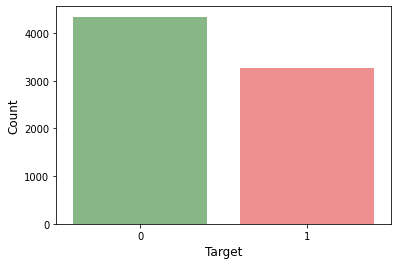

In [0]:
plt.style.use('fast')

sns.barplot(train.target.value_counts().index, train.target.value_counts().values, alpha=0.5, palette=["green", 'red'])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Target', fontsize=12)
plt.show()

<br>

Wee see that there is a slight imbalance in favor of beinign (non-disaster) tweets. The imbalance, however, is not so large that it will significantly effect our modelling.

## Exploratory Data Analysis

#### Characters per tweet

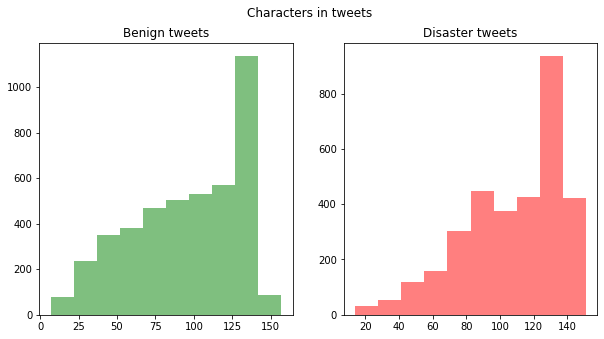

In [0]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=train[train['target']==0]['text'].str.len()
ax1.hist(tweet_len,color='green', alpha = 0.5)
ax1.set_title('Benign tweets')
tweet_len=train[train['target']==1]['text'].str.len()
ax2.hist(tweet_len,color='red', alpha = 0.5)
ax2.set_title('Disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

#### Words per tweet

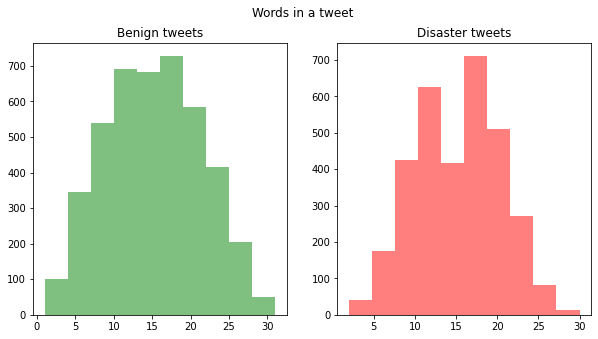

In [0]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=train[train['target']==0]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='green', alpha = 0.5)
ax1.set_title('Benign tweets')
tweet_len=train[train['target']==1]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='red', alpha = 0.5)
ax2.set_title('Disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

#### Average word length per tweet

Text(0.5, 0.98, 'Average word length in each tweet')

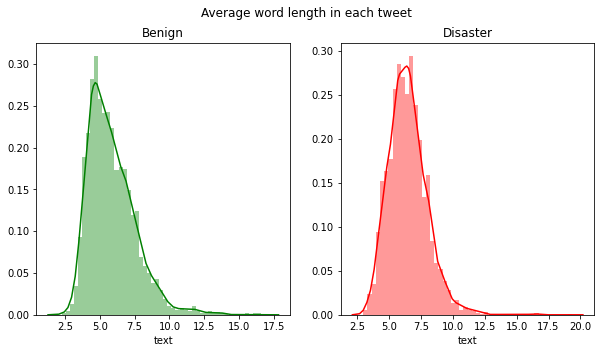

In [0]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=train[train['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='green')
ax1.set_title('Benign')
word=train[train['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='red')
ax2.set_title('Disaster')
fig.suptitle('Average word length in each tweet')

#### N-Gram analysis

In [0]:
# https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove

def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

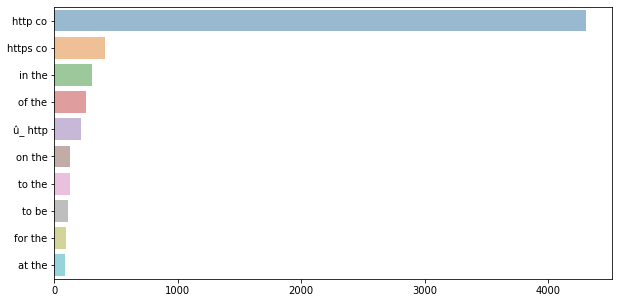

In [0]:
plt.figure(figsize=(10,5))
top_tweet_bigrams = get_top_tweet_bigrams(train['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x, alpha = 0.5)

<br>

## Identifying and Treating Discrepancies

### Mis-labelled tweets

Here, I draw from the work done [here](https://www.kaggle.com/muhammedfathi/fake-or-real-with-bert) to identify and relabel tweets that have erroneously been labeled as disasters.

This step is important to ensure that our model is not learning patterns from incorrect data.

In [0]:
ids_with_target_error = [328,443,513,2619,3640,3900,4342,5781,6552,6554,6570,6701,6702,6729,6861,7226]
train[train['id'].isin(ids_with_target_error)][['text', 'target']]

,text,target
229,Ready to get annihilated for the BUCS game,1
301,Short Reading\n\nApocalypse 21:1023 \n\nIn the spirit the angel took me to the top of an enormous high mountain and... http://t.co/v8AfTD9zeZ,1
356,But if you build an army of 100 dogs and their leader is a lion all dogs will fight like a lion.,1
1822,My iPod crashed..... \n#WeLoveYouLouis \n#MTVHottest One Direction,1
2536,This desperation dislocation\nSeparation condemnation\nRevelation in temptation\nIsolation desolation\nLet it go and so to find away,1
2715,Man Currensy really be talkin that talk... I'd be more devastated if he had a ghostwriter than anybody else....,1
3024,Going to a fest? Bring swimming goggles for the dust storm in the circle pit,1
4068,Campsite recommendations \nToilets /shower \nPub \nFires \nNo kids \nPizza shop \nForest \nPretty stream \nNo midges\nNo snakes\nThanks ??,1
4609,My prediction for the Vikings game this Sunday....dont expect a whole lot. Infact I think Zimmer goal is....injury free 1st game,1
4611,Dante Exum's knee injury could stem Jazz's hoped-for surge back to ... http://t.co/8PIFutrB5U,1


Having identified the mis-labelled tweets, the code below re-labels them as 0.

In [0]:
train.at[train['id'].isin(ids_with_target_error),'target'] = 0
train[train['id'].isin(ids_with_target_error)][['text', 'target']]

,text,target
229,Ready to get annihilated for the BUCS game,0
301,Short Reading\n\nApocalypse 21:1023 \n\nIn the spirit the angel took me to the top of an enormous high mountain and... http://t.co/v8AfTD9zeZ,0
356,But if you build an army of 100 dogs and their leader is a lion all dogs will fight like a lion.,0
1822,My iPod crashed..... \n#WeLoveYouLouis \n#MTVHottest One Direction,0
2536,This desperation dislocation\nSeparation condemnation\nRevelation in temptation\nIsolation desolation\nLet it go and so to find away,0
2715,Man Currensy really be talkin that talk... I'd be more devastated if he had a ghostwriter than anybody else....,0
3024,Going to a fest? Bring swimming goggles for the dust storm in the circle pit,0
4068,Campsite recommendations \nToilets /shower \nPub \nFires \nNo kids \nPizza shop \nForest \nPretty stream \nNo midges\nNo snakes\nThanks ??,0
4609,My prediction for the Vikings game this Sunday....dont expect a whole lot. Infact I think Zimmer goal is....injury free 1st game,0
4611,Dante Exum's knee injury could stem Jazz's hoped-for surge back to ... http://t.co/8PIFutrB5U,0


### Semantically identical tweets

In addition to mis-labelled tweets, there are duplicated tweets, many of which have inconsistent labels. This draws from the work done [here](https://www.kaggle.com/dmitri9149/transformer-svm-semantically-identical-tweets). Rather than merely ensuring consistency among duplicate tweets, I will find all duplicates, regardless of label consistency, and remove all but one. To do this, I define some helper functions based on code found [here](https://www.quora.com/How-do-I-calculate-Cosine-Similarity-between-tweets).

#### Helper functions

The first helper function serves to create a dictionary from the text passed. The dictionary keys are the words in the text and the values are the frequency of those words.

In [0]:
import re, math
from collections import Counter

WORD = re.compile(r'\w+')

def iNeedAVector(text):
     words = WORD.findall(text)
     return Counter(words)

Using the iNeedAVector function, I create a new column in the training dataframe that contains the corresponding dictionary for each tweet.

In [0]:
train['vector'] = train['text'].map(lambda x: iNeedAVector(x))
train

,id,keyword,location,text,target,vector
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,"{'Our': 1, 'Deeds': 1, 'are': 1, 'the': 1, 'Reason': 1, 'of': 1, 'this': 1, 'earthquake': 1, 'May': 1, 'ALLAH': 1, 'Forgive': 1, 'us': 1, 'all': 1}"
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,"{'Forest': 1, 'fire': 1, 'near': 1, 'La': 1, 'Ronge': 1, 'Sask': 1, 'Canada': 1}"
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,"{'All': 1, 'residents': 1, 'asked': 1, 'to': 1, 'shelter': 2, 'in': 2, 'place': 2, 'are': 2, 'being': 1, 'notified': 1, 'by': 1, 'officers': 1, 'No': 1, 'other': 1, 'evacuation': 1, 'or': 1, 'orders': 1, 'expected': 1}"
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1,"{'13': 1, '000': 1, 'people': 1, 'receive': 1, 'wildfires': 1, 'evacuation': 1, 'orders': 1, 'in': 1, 'California': 1}"
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,"{'Just': 1, 'got': 1, 'sent': 1, 'this': 1, 'photo': 1, 'from': 2, 'Ruby': 1, 'Alaska': 1, 'as': 1, 'smoke': 1, 'wildfires': 1, 'pours': 1, 'into': 1, 'a': 1, 'school': 1}"
...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,1,"{'Two': 1, 'giant': 1, 'cranes': 1, 'holding': 1, 'a': 1, 'bridge': 1, 'collapse': 1, 'into': 1, 'nearby': 1, 'homes': 1, 'http': 1, 't': 1, 'co': 1, 'STfMbbZFB5': 1}"
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.,1,"{'aria_ahrary': 1, 'TheTawniest': 1, 'The': 1, 'out': 1, 'of': 2, 'control': 1, 'wild': 1, 'fires': 1, 'in': 2, 'California': 1, 'even': 1, 'the': 2, 'Northern': 1, 'part': 1, 'state': 1, 'Very': 1, 'troubling': 1}"
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,1,"{'M1': 1, '94': 1, '01': 1, '04': 1, 'UTC': 1, '5km': 1, 'S': 1, 'of': 1, 'Volcano': 1, 'Hawaii': 1, 'http': 1, 't': 1, 'co': 1, 'zDtoyd8EbJ': 1}"
7611,10872,NaN,NaN,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.,1,"{'Police': 1, 'investigating': 1, 'after': 1, 'an': 1, 'e': 1, 'bike': 2, 'collided': 1, 'with': 1, 'a': 1, 'car': 1, 'in': 1, 'Little': 1, 'Portugal': 1, 'E': 1, 'rider': 1, 'suffered': 1, 'serious': 1, 'non': 1, 'life': 1, 'threatening': 1, 'injuries': 1}"


With the newly created column, I can compute the cosine similarity between pairs of tweets using the function below.

In [0]:
def iNeedACosine(v1, v2):
     intersection = set(v1.keys()) & set(v2.keys())
     nume = sum([v1[x] * v2[x] for x in intersection])
     test1 = sum([v1[x]**2 for x in v1.keys()])
     test2 = sum([v2[x]**2 for x in v2.keys()])
     den = math.sqrt(test1) * math.sqrt(test2)
     if not den:
        return 0.0
     else:
        return float(nume) / den

Cosine similarity measures the cosine angle between tow vectors projected in multi-dimensional space. This is a better measure of similarity than Euclidean distance, because it can identify similarity among documents of different sizes. The smaller the angle, the higher cosine similarity.

<br>

With the newly defined functions, I loop over each of the tweets in the train set and calculate the cosine similarity with all other tweets. Tweets with cosine similarity greater than 90% are stored in a dictionary (`similar`) with the following structure:

- **Keys**: Base tweet
- **Values**: Array of tweets with cosine similarty above 90% with the base tweet.

<br>

Tweets that have been captured as values for a base tweet are stored in an array (`tested`), preventing them from being looped over again.

#### Searching for similar tweets

In [0]:
from collections import defaultdict

similar = defaultdict(list)
tested = []

for i in range(len(train)):
  if i not in tested:
    for j in range(len(train)):
      if j > i and j not in tested:
        sim = iNeedACosine(train['vector'][i], train['vector'][j])
        if sim > 0.9:
          tested.append(j)
          similar[i].append(j)
  # if i in similar.keys():
  #   print(i, similar[i])

Before continuing, I create a dictionary for similar tweets in the test set as well. These may be useful later on, if there are descrepancies in predicted labels for the test set.

In [0]:
test['vector'] = test['text'].map(lambda x: iNeedAVector(x))

In [0]:
similar_test = defaultdict(list)
tested = []

for i in range(len(test)):
  if i not in tested:
    for j in range(len(test)):
      if j > i and j not in tested:
        sim = iNeedACosine(test['vector'][i], test['vector'][j])
        if sim > 0.9:
          tested.append(j)
          similar_test[i].append(j)
  # if i in similar_test.keys():
  #   print(i, similar_test[i])

To avoid having to run the loops above repeatedly, the objects, `similar` and `similar_test`, are saved using `pickle` with the code below.

In [0]:
with open('similar_tweets.pkl', 'wb') as f:
    pickle.dump([similar, similar_test], f)

With the objects saved, we can simply load them when needed using the code below.

In [0]:
with open('similar_tweets.pkl', 'rb') as f:
    similar, similar_test = pickle.load(f)

#### Exploring similar tweets

In [0]:
print('{} duplicated tweets in the train set.'.format(len(similar)))
print('{} duplicate tweets in the test set.'.format(len(similar_test)))

342 duplicated tweets in the train set.
113 duplicate tweets in the test set.


As we see, there are many tweets that are very similar. Some of these tweets have inconsitent labels. See the example below.

In [0]:
similar_group = [4391, 4392, 4393, 4394, 4396, 4397, 4399, 4400, 4403, 4404, 4405, 4407, 4408, 4412, 4414, 4415, 4420]
train.loc[similar_group,['text','target']]

,text,target
4391,#hot Funtenna: hijacking computers to send data as sound waves [Black Hat 2015] http://t.co/gUJNPLJVvt #prebreak #best,0
4392,#hot Funtenna: hijacking computers to send data as sound waves [Black Hat 2015] http://t.co/J2aQs5loxu #prebreak #best,1
4393,#hot Funtenna: hijacking computers to send data as sound waves [Black Hat 2015] http://t.co/s4PNIhJQX7 #prebreak #best,0
4394,#hot Funtenna: hijacking computers to send data as sound waves [Black Hat 2015] http://t.co/cx6auPneMu #prebreak #best,0
4396,#hot Funtenna: hijacking computers to send data as sound waves [Black Hat 2015] http://t.co/wvTPuRYx63 #prebreak #best,0
4397,#hot Funtenna: hijacking computers to send data as sound waves [Black Hat 2015] http://t.co/J5onxFwLAo #prebreak #best,0
4399,#hot Funtenna: hijacking computers to send data as sound waves [Black Hat 2015] http://t.co/nQiObcZKrT #prebreak #best,0
4400,#hot Funtenna: hijacking computers to send data as sound waves [Black Hat 2015] http://t.co/aAtt5aMnmD #prebreak #best,0
4403,#hot Funtenna: hijacking computers to send data as sound waves [Black Hat 2015] http://t.co/qj3PVgaVN7 #prebreak #best,1
4404,#hot Funtenna: hijacking computers to send data as sound waves [Black Hat 2015] http://t.co/6AqrNanKFD #prebreak #best,0


We will deal with duplicate tweets by removing all but one and assigning 1 or 0, according to which side of 0.5 the mean of the labels is on. For example, the 17 dupicates above only have five '1' labels. Therefore, the mean is close to zero and a zero label will be assigned. This is appropriate given the tweet's content.

<br>

For tweets that are split, 50/50, I will manually label them, if there aren't too many. If there are too many, I could assign them a default value or a random value.

#### Treating duplicates

The length of the train set prior to dealing with duplicates is printed here.

In [0]:
len(train)

7613

The code below serves to take the mean label value of all duplicate tweets and assign new values for the base tweets. Following this, non-base tweets are removed. Target values are assigned according to the following scheme:

- **1** - mean label of duplicates is _above_ 0.5
- **0** - mean label of duplicates is _below_ 0.5
- **0.5** - mean label of duplicates _equal_ 0.5

In [0]:
for k in similar.keys():
  summation = train.loc[similar[k],:]['target'].sum() + train.loc[k,:]['target']
  count = len(similar[k]) + 1
  mean = summation/count
  if mean > 0.5:
    train.loc[k,'target'] = 1
  elif mean < 0.5:
    train.loc[k,'target'] = 0
  else:
    train.loc[k,'target'] = 0.5
  train = train.drop(similar[k])

train = train.reset_index(drop=True)

The new length of the train set can be seen below.

In [0]:
len(train)

6842

#### Manually assigning labels

Below is printed the number of tweets that have been labelled `0.5`, corresponding to split vote among duplicated tweets regarding which label to assign.

In [0]:
len(train[train['target'] == 0.5])

40

We see that 40 tweets were assigned 0.5, because the vote was split. This is a relatively low number. Proper labels can be assigned manually.

In [0]:
print(train[train['target'] == 0.5][['text']])

                                                                                                                                                      text
224                            World Annihilation vs Self Transformation http://t.co/pyehwodWun Aliens Attack to Exterminate Humans http://t.co/pB2N77nSKz
471                         STAR WARS POWER OF THE JEDI COLLECTION 1 BATTLE DROID HASBRO - Full read by eBay http://t.co/xFguklrlTf http://t.co/FeGu8hWMc4
509                                             #world FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps  http://t.co/wvExJjRG6E
525                                                                                                                             To fight bioterrorism sir.
1054            Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/985DwWPdEt
1079                                                                  

Having read each tweet individually, I have created a dictionary with the **tweet index** and the **manually assigned label**

In [0]:
manual_labels = {
    224:0, 471:0, 509:1, 525:0, 1054:1,
    1079:0, 1096:0, 1103:0, 1112:1, 1947:0,
    1971:0, 2076:0, 2292:0, 2442:0, 2445:0,
    2656:0, 2807:1, 2880:0, 3319:0, 3372:1,
    3698:0, 3849:0, 3897:0, 4008:0, 4009:0,
    4341:0, 4475:0, 4816:0, 5036:0, 5060:0,
    5174:0, 5198:1, 5225:0, 5468:0, 5947:0,
    5960:0, 6006:0, 6141:0, 6251:0, 6660:0
}

for k,v in manual_labels.items():
  train.loc[k,'target'] = v

In [0]:
len(train[train['target'] == 0.5])

0

All split votes have been resolved. Next, I will establish some baseline models upon which I can improve with cleaning.

<br>
<br>

# 3. Baseline Models

In this section, I establish baseline Logistic Regression, Naive Bayes, and Support Vector Machine (SVM) models. Prior to doing so, I create embedded documents of the tweets using one of the universal sentence encoder created by Google.

<br>

For each family, I train different algorithms. See below:

- **Logistic Regression** - _Basic Logistic Regression_ and _Ridge Classifier_ models are trained.
- **Naive Bayes** - _Bernoulli Naive Bayes_ and _Gaussian Bayes_ models are trained.
- **SVM** - _Basic Support Vector Classifier_ and _Nu-Support Vector Classifier_ models are trained.

<br>

Where appropriate, hyper-parameters are optimized and the models are evaluated using 5-fold cross-validation. This gives us good baselines upon which to improve.

<br>

Finally, I used the three most promissing models to predict the labels for the test set and submitted the results to Kaggle. I also used a stacking ensemble approach to see if results of the three models combined were better.

In [0]:
# !pip install --user tensorflow_text

In [0]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.svm import LinearSVC, SVC, NuSVC
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import tensorflow_hub as hub
import tensorflow as tf
import tensorflow_text

from functools import partial 
from tqdm import tqdm #for progress bar

cv = 5
rs = 123
np.random.seed(rs)

## Vectorize

To vectorize the text, I use the multilingual universal sentence encoder from [TensorFlow Hub](https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3), which was published by Google and is designed for text classification tasks such as ours.

<br>

First, I must load the the encoder directly from the webpage using the code below.

In [0]:
use = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3")

With the universal encoder loaded, I loop over each tweet and create a sentence embedding for it. Each of these embeddings is then appended to an array. This is done for both the train and test sets.

In [0]:
X_train = []
for r in tqdm(train.text.values):
  emb = use(r)
  review_emb = tf.reshape(emb, [-1]).numpy()
  X_train.append(review_emb)

X_train = np.array(X_train)
y_train = train.target.values

X_test = []
for r in tqdm(test.text.values):
  emb = use(r)
  review_emb = tf.reshape(emb, [-1]).numpy()
  X_test.append(review_emb)

X_test = np.array(X_test)

100%|██████████| 3263/3263 [00:40<00:00, 80.11it/s]


Having created embeddings for the tweets in the two dataframes, I save them to avoid having to repeat this step.

In [0]:
with open('sentence_embeddings.pkl', 'wb') as f:
    pickle.dump([X_train, y_train, X_test], f)

The code below can be used to reload the previously saved arrays of embedded tweets.

In [0]:
with open('sentence_embeddings.pkl', 'rb') as f:
    X_train, y_train, X_test = pickle.load(f)

Here, train and test sets are created in preperation for modelling. Test size is set to 20% of the entire training set.

In [0]:
X, test_arrays, y, test_labels = train_test_split(X_train, y_train, random_state = rs, test_size = 0.2)

## Baseline Logistic Regression

Here, two logistic regressions are trained and optimized. One is a basic logistic regression and the other is a ridge classifier.

The main difference between the two is the loss function. While logisitic regression uses a cross-entropy loss, ridge does not ([source](https://stackoverflow.com/questions/53911663/what-does-sklearn-ridgeclassifier-do/53912015)).

### Basic Logistic Regression

In [0]:
def lr_param_selection(X, y, folds=cv, random_state=rs):
  param_grid = {
      'penalty': ['l1', 'l2', 'elasticnet', 'none'],
      'C': np.arange(0.1, 1.0, 0.1),
      'fit_intercept': [True, False],
      'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
      }
  random_search = RandomizedSearchCV(LogisticRegression(max_iter=10000, random_state=random_state), param_grid, cv = folds, n_jobs = 8)
  random_search.fit(X, y)
  random_search.best_params_
  return random_search

lr_model = lr_param_selection(X, y)

In [0]:
cross_val_score(lr_model, X, y, cv=cv, scoring="f1").mean()

0.7567454231456395

In [0]:
print("F1-Score: %.2f" % f1_score(test_labels, lr_model.predict(test_arrays)))
print(classification_report(test_labels, lr_model.predict(test_arrays)))

F1-Score: 0.75
              precision    recall  f1-score   support

         0.0       0.81      0.88      0.84       808
         1.0       0.81      0.70      0.75       561

    accuracy                           0.81      1369
   macro avg       0.81      0.79      0.79      1369
weighted avg       0.81      0.81      0.80      1369



### Ridge Classifier

In [0]:
def rc_param_selection(X, y, folds=cv, random_state=rs):
  param_grid = {
      'alpha': np.arange(0, 3, 0.1),
      'fit_intercept': [True, False],
      'normalize': [True, False],
      'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
      }
  random_search = RandomizedSearchCV(RidgeClassifier(max_iter=10000, random_state=random_state), param_grid, cv = folds, n_jobs = 8)
  random_search.fit(X, y)
  random_search.best_params_
  return random_search

rc_model = rc_param_selection(X, y)

In [0]:
cross_val_score(rc_model, X, y, cv=cv, scoring="f1").mean()

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


0.7567670671793278

In [0]:
print("F1-Score: %.2f" % f1_score(test_labels, rc_model.predict(test_arrays)))
print(classification_report(test_labels, rc_model.predict(test_arrays)))

F1-Score: 0.72
              precision    recall  f1-score   support

         0.0       0.79      0.90      0.84       808
         1.0       0.81      0.65      0.72       561

    accuracy                           0.79      1369
   macro avg       0.80      0.77      0.78      1369
weighted avg       0.80      0.79      0.79      1369



## Baseline Naive Bayes

### Bernoulli Naive Bayes

In [0]:
def bnb_param_selection(X, y, folds=cv, random_state=rs):
  param_grid = {
      'alpha': np.arange(0, 3, 0.1)
      }
  random_search = RandomizedSearchCV(BernoulliNB(), param_grid, cv = folds, n_jobs = 8)
  random_search.fit(X, y)
  random_search.best_params_
  return random_search

bnb_model = bnb_param_selection(X, y)

In [0]:
cross_val_score(bnb_model, X, y, cv=cv, scoring="f1").mean()

0.7380695061583131

In [0]:
print("F1-Score: %.2f" % f1_score(test_labels, bnb_model.predict(test_arrays)))
print(classification_report(test_labels, bnb_model.predict(test_arrays)))

F1-Score: 0.71
              precision    recall  f1-score   support

         0.0       0.79      0.82      0.80       808
         1.0       0.72      0.70      0.71       561

    accuracy                           0.77      1369
   macro avg       0.76      0.76      0.76      1369
weighted avg       0.77      0.77      0.77      1369



### Gaussian Naive Bayes

Explanation

In [0]:
gnb = GaussianNB()
# gnb.fit(X, y)

cross_val_score(gnb, X, y, cv=cv, scoring="f1").mean()

0.7477351007039822

In [0]:
print("F1-Score: %.2f" % f1_score(test_labels, gnb.predict(test_arrays)))
print(classification_report(test_labels, gnb.predict(test_arrays)))

F1-Score: 0.71
              precision    recall  f1-score   support

         0.0       0.80      0.81      0.81       808
         1.0       0.72      0.70      0.71       561

    accuracy                           0.77      1369
   macro avg       0.76      0.76      0.76      1369
weighted avg       0.77      0.77      0.77      1369



## Baseline SVMs

### Basic Support Vector Classifier

In [0]:
def svc_param_selection(X, y, folds=cv, random_state=rs):
    param_grid = {
        'C': [1.070, 1.074, 1.075, 1.1, 1.125],
        'gamma' : [2.065,2.075, 2.08]}
    random_search = RandomizedSearchCV(SVC(kernel='rbf'), param_grid, cv = folds, n_jobs = -1, random_state = random_state)
    random_search.fit(X, y)
    random_search.best_params_
    return random_search

svc_model = svc_param_selection(X, y)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [0]:
cross_val_score(svc_model, X, y, cv=cv, scoring="f1").mean()

0.7652937127625976

In [0]:
print("F1-Score: %.2f" % f1_score(test_labels, svc_model.predict(test_arrays)))
print(classification_report(test_labels, svc_model.predict(test_arrays)))

F1-Score: 0.76
              precision    recall  f1-score   support

         0.0       0.81      0.91      0.86       808
         1.0       0.85      0.69      0.76       561

    accuracy                           0.82      1369
   macro avg       0.83      0.80      0.81      1369
weighted avg       0.82      0.82      0.82      1369



### Nu-Support Vector Classifier

In [0]:
def nsvc_param_selection(X, y, folds=cv, random_state=rs):
    param_grid = {
        'nu': np.arange(0.1, 1.0, 0.1),
        'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
        'degree': range(1, 10),
        'gamma': ['scale', 'auto'],
        'coef0': np.arange(0, 1, 0.05),
        'shrinking': [True, False],
        'probability':[True, False],
        'decision_function_shape': ['ovo', 'ovr']
        }
    random_search = RandomizedSearchCV(NuSVC(), param_grid, cv=folds, n_jobs=-1, random_state=random_state)
    random_search.fit(X, y)
    random_search.best_params_
    return random_search

nsvc_model = nsvc_param_selection(X, y)

In [0]:
cross_val_score(nsvc_model, X, y, cv=cv, scoring='f1').mean()

In [0]:
print("F1-Score: %.2f" % f1_score(test_labels, nsvc_model.predict(test_arrays)))
print(classification_report(test_labels, nsvc_model.predict(test_arrays)))

F1-Score: 0.73
              precision    recall  f1-score   support

         0.0       0.79      0.90      0.84       808
         1.0       0.82      0.66      0.73       561

    accuracy                           0.80      1369
   macro avg       0.81      0.78      0.79      1369
weighted avg       0.80      0.80      0.80      1369



## Save and Predict

Here, I save the models and make predictions on the test set using the optimized Logistic Regression, Bernoulli Naive Bayes and Support Vector Classifier. I also stack the three and take the majority vote.

<br>

For each of the predictions, a loop is used to label tweets with high cosine similarity with '1' or '0' depending on what is most popular among the similar tweets. This is a similar approach to what was used earlier for similar tweets in the training set, except that here, tweets aren't removed. The majority label is simply applied to all the tweets in the group.

In [0]:
from joblib import dump, load

In [0]:
dump(lr_model, 'lr_base_model.joblib')
dump(rc_model, 'rc_base_model.joblib')
dump(bnb_model, 'bnb_base_model.joblib')
dump(svc_model, 'svc_base_model.joblib')
dump(nsvc_model, 'nsvc_base_model.joblib')

['nsvc_base_model.joblib']

In [0]:
lr_model = load('lr_base_model.joblib')
rc_model = load('rc_base_model.joblib')
bnb_model = load('bnb_base_model.joblib')
svc_model = load('svc_base_model.joblib')
nsvc_model = load('nsvc_base_model.joblib')

### Make Predictions

Here, four sets of predictions are made, with one being the stacked prediction of the other three.

In [0]:
lr_pred = lr_model.predict(X_test)
bnb_pred = bnb_model.predict(X_test)
svc_pred = svc_model.predict(X_test)

In [0]:
submission['target'] = lr_pred

for k in similar_test.keys():
  summation = submission.loc[similar_test[k],:]['target'].sum() + submission.loc[k,:]['target']
  count = len(similar[k]) + 1
  mean = summation/count
  if mean > 0.5:
    submission.loc[k,'target'] = 1
    submission.loc[similar_test[k],'target'] = 1
  else:
    submission.loc[k,'target'] = 0
    submission.loc[similar_test[k],'target'] = 0

submission.to_csv('base_lr_submission.csv', index = False)

In [0]:
submission['target'] = bnb_pred

for k in similar_test.keys():
  summation = submission.loc[similar_test[k],:]['target'].sum() + submission.loc[k,:]['target']
  count = len(similar[k]) + 1
  mean = summation/count
  if mean > 0.5:
    submission.loc[k,'target'] = 1
    submission.loc[similar_test[k],'target'] = 1
  else:
    submission.loc[k,'target'] = 0
    submission.loc[similar_test[k],'target'] = 0

submission.to_csv('base_bnb_submission.csv', index = False)

In [0]:
submission['target'] = svc_pred

for k in similar_test.keys():
  summation = submission.loc[similar_test[k],:]['target'].sum() + submission.loc[k,:]['target']
  count = len(similar[k]) + 1
  mean = summation/count
  if mean > 0.5:
    submission.loc[k,'target'] = 1
    submission.loc[similar_test[k],'target'] = 1
  else:
    submission.loc[k,'target'] = 0
    submission.loc[similar_test[k],'target'] = 0

submission.to_csv('base_svc_submission.csv', index = False)

### Initial Kaggle Submission

Of the predictions made, only the stacked prediction was submitted to Kaggle. The prediction was established using the code below.

In [0]:
stack_pred = []

for i in range(len(lr_pred)):
  if (lr_pred[i] + bnb_pred[i] + svc_pred[i]) >= 2:
    stack_pred.append(1)
  else:
    stack_pred.append(0)
    

submission['target'] = stack_pred

for k in similar_test.keys():
  summation = submission.loc[similar_test[k],:]['target'].sum() + submission.loc[k,:]['target']
  count = len(similar[k]) + 1
  mean = summation/count
  if mean > 0.5:
    submission.loc[k,'target'] = 1
    submission.loc[similar_test[k],'target'] = 1
  else:
    submission.loc[k,'target'] = 0
    submission.loc[similar_test[k],'target'] = 0

submission.to_csv('base_stacked_submission.csv', index = False)
# F1_score: 0.81799

**KAGLE SCORE:** 81.799

This initial prediction yielded a relatively good score, despite no cleaning having been done to the text. I try to improve upon this score below.

# 4. Further Cleaning and Modelling

In this section, I clean the text in the training set in an attempt to improve model performance. The two models selected for further fine-tuning are:

1. Basic Logistic Regression
2. Basic Support Vector Classifier


At every step of text cleaning, a model is trained and evaluated to determine if the cleaning step improved, hindered or had no effect on performance. This approach slows down training, but is likely to lead to more robust results.

In [0]:
# !pip install colorama
# !pip install pyspellchecker

In [0]:
import nltk
import re
import string
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
from spellchecker import SpellChecker
import unicodedata
from colorama import Fore, Style

nltk.download('punkt')
nltk.download('stopwords')

tfidf = TfidfVectorizer(min_df=5)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<br>

## Logistic Regression

### Setup

Here, I define some objects that will be used throughout this section.

In [0]:
reference = 'processed_text_lr'
train['processed_text_lr'] = train['text'].copy()
clf = lr_model
# base = cross_val_score(clf, X, y, cv=cv, scoring="f1").mean()
baseline = base.copy()
cv = 5

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


#### Helper Dictionaries

Here, two dictionaries are defined, which will be used later in the cleaning process. One is for the expansion of contraction, which was retrieved from [here](https://github.com/dipanjanS/practical-machine-learning-with-python/blob/master/bonus%20content/nlp%20proven%20approach/contractions.py). The other is for the expansion of abbreviations, which was pulled from [here](https://www.kaggle.com/nmaguette/up-to-date-list-of-slangs-for-text-preprocessing/).

In [0]:
# https://github.com/dipanjanS/practical-machine-learning-with-python/blob/master/bonus%20content/nlp%20proven%20approach/contractions.py

CONTRACTION_MAP = {
    "ain't": "is not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "I'd": "I would",
    "I'd've": "I would have",
    "I'll": "I will",
    "I'll've": "I will have",
    "I'm": "I am",
    "I've": "I have",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
}

In [0]:
# https://www.kaggle.com/nmaguette/up-to-date-list-of-slangs-for-text-preprocessing/

abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "2k10": "2010",
    "2k11": "2011",
    "2k12": "2012",
    "2k13": "2013",
    "2k14": "2014",
    "2k15": "2015",
    "2k16": "2016",
    "2k17": "2017",
    "2k18": "2018",
    "2k19": "2019",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmaoo" : "laugh my ass off",
    "lmaaoo" : "laugh my ass off",
    "lmaao" : "laugh my ass off",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lool" : "laughing out loud",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

#### Helper Functions

Below are a number of useful user-defined functions that will aid throughout the cleaning process. Though they will be described in more detail when used, one in particular are worth highlighting here:

- **try_step()** - this function takes a function as its input, as well as other optional arguments, and applies the function to the corpus, saving the results in a temporary column. It then trains and evaluates a model on the new column to determine if the function improved performance. If it did, then the changes are applied to the `processed_text` column and the baseline score is updated. This function allows for the evaluation of different cleaning approaches.

In [0]:
def try_step(function, vectorizer = 'universal', model = clf, base = baseline, reference = reference, target = 'temp', scoring = 'f1', folds = cv, coerce = False, random_state = rs, **kwargs):
  """
  This function takes a function as its input, as well as other optional arguments.
  It applies the function to the text and computes the resultant change in the target metric (F1-Score by default).
  """
  global baseline

  train[target] = train[reference].apply(lambda x: function(x, **kwargs))

  if vectorizer == 'basic':
    X_train, X_test, y, y_test = train_test_split(train[target], train['target'], random_state = random_state)
    X = tfidf.fit_transform(X_train)
    score = cross_val_score(model, X, y, cv = folds, scoring = scoring).mean()
    
  if vectorizer == 'universal':
    X_temp = []
    
    for r in tqdm(train[reference].values):
      emb = use(r)
      review_emb = tf.reshape(emb, [-1]).numpy()
      X_temp.append(review_emb)

    X_temp = np.array(X_temp)
    y_train = train['target'].values
    X, test_arrays, y, test_labels = train_test_split(X_temp, y_train, random_state = random_state, test_size = 0.3)

  score = cross_val_score(model, X, y, cv = folds, scoring = scoring).mean()
  
  print("Result: \t\t %.4f" % (score))
  print("Previous baseline: \t %.4f" % (baseline))
  
  if score > baseline:
    print(Fore.GREEN + "Improvement of: \t %.4f" % (np.round(score, 4) - np.round(baseline, 4)))
    baseline = score
    print(Fore.BLACK + "\nNew baseline: \t\t %.4f" % (baseline))
    train[reference] = train[target]
  
  elif score == baseline:
    print(Fore.BLACK + "\nThis step does not change the baseline.")
    train[reference] = train[target]

  else:
    print(Fore.RED + "Reduction of: \t\t%.4f" % (score - baseline))
    print(Fore.BLACK + "\nPrevious baseline remains the best.")
  
  if coerce:
    train[reference] = train[target]
    baseline = score
    print('\nChange coerced')
  
  del train[target]



def get_words(reference):
  all_words = []

  for tweet in reference:
    table = str.maketrans('','',string.punctuation)
    text = tweet.translate(table)
    for word in text.split():
      if word.lower() not in all_words:
        all_words.append(word.lower())

  return all_words


def replace_expression(text, expression, replace_with):
  text = re.sub(expression, replace_with, text)
  return text


def standardize_text(text):
  text = text.replace(r"http\S+", "")
  text = text.replace(r"http", "")
  text = text.replace(r"@\S+", "")
  text = text.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
  text = text.replace(r"@", "at ")
  text = text.replace(r"#", "hashtag ")
  text = text.lower()
  return text


def spacing(text):
  text = text.replace(r'\t', ' ')
  text = text.replace(r'\n', ' ')
  text = text.replace(r"\s+", " ")
  return text


def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  stripped_text = soup.get_text()
  return stripped_text


def remove_punct(text, punctuation):
  table=str.maketrans('','', punctuation)
  return text.translate(table)


def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text


def stemming(text):
  stemmer = SnowballStemmer("english")
  text = [stemmer.stem(word) for word in text.split()]
  return " ".join(text)


mycompile = lambda pat:  re.compile(pat, re.UNICODE)

NormalEyes = r'[:]'
Wink = r'[;]'

NoseArea = r'(o|O|-)'

HappyMouths = r'[D\)\]]'
SadMouths = r'[\(\[]'
Tongue = r'[pP]'
OtherMouths = r'[doO/\\]'

happy_regex =  mycompile( '(\^_\^|' + NormalEyes + NoseArea + HappyMouths + ')')
sad_regex = mycompile(NormalEyes + NoseArea + SadMouths)
wink_regex = mycompile(Wink + NoseArea + HappyMouths)
tongue_regex = mycompile(NormalEyes + NoseArea + Tongue)
other_regex = mycompile( '('+NormalEyes+'|'+Wink+')'  + NoseArea + OtherMouths )

Emoticon = (
    "("+NormalEyes+"|"+Wink+")" +
    NoseArea + 
    "("+Tongue+"|"+OtherMouths+"|"+SadMouths+"|"+HappyMouths+")"
)

emoticon_regex = mycompile(Emoticon)

def happy_repl(match):
  return '_HAPPY_'+match.group(1).upper()

def sad_repl(match):
  return '_SAD_'+match.group(1).upper()

def wink_repl(match):
  return '_WINK_'+match.group(1).upper()

def emoticons(text):
  text = re.sub( happy_regex, happy_repl, text )
  text = re.sub( sad_regex, sad_repl, text )
  text = re.sub( wink_regex, wink_repl, text )
  return text


spell = SpellChecker()
def correct_spellings(text):
  corrected_text = []
  misspelled_words = spell.unknown(text.split())
  for word in text.split():
      if word in misspelled_words:
          corrected_text.append(spell.correction(word))
          print(word, ' '*(20-len(word)), "===>\t", spell.correction(word))
      else:
          corrected_text.append(word)
  return " ".join(corrected_text)


def remove_stopwords(text, words):
  tokens = [x for x in word_tokenize(text) if x.lower() not in words]
  return " ".join(tokens)


def stopwords_to_remove(words, baseline, reference, vectorizer = 'basic', cv = cv, clf = clf, scoring = 'f1', random_state = rs):
  stop = []
  i = 1

  for word in words:
    stop.append(word)
    train['temp'] = reference.apply(remove_stopwords, words = stop)

    if vectorizer == 'universal':
      X_temp = []
    
      for r in tqdm(train['temp'].values):
        emb = use(r)
        review_emb = tf.reshape(emb, [-1]).numpy()
        X_temp.append(review_emb)

      X_temp = np.array(X_temp)
      y_train = train['target'].values
      X, test_arrays, y, test_labels = train_test_split(X_temp, y_train, random_state = random_state, test_size = 0.3)
      score = cross_val_score(clf, X, y, cv = cv, scoring = scoring).mean()

    if vectorizer == 'basic':
      X, X_t, y, y_t = train_test_split(train['temp'], train['target'], random_state = random_state)
      X = tfidf.fit_transform(X)
      score = cross_val_score(clf, X, y, cv = cv, scoring = scoring).mean()
    
    
    print("{}%\t".format(np.round((i/len(all_stopwords)*100), 2)), np.round(score, 4),'    \t', stop)
    i += 1

    if score > baseline:
      baseline = score
      reference = reference.apply(remove_stopwords, words = stop)
      
    else:
      stop.remove(word)
  
  print('\nSelected stopwords to remove:\n', stop)
  return stop


def convert_abbrev(word, words):
  return words[word.lower()] if word.lower() in words.keys() else word


def convert_abbrev_in_text(text, words):
  tokens = word_tokenize(text)
  tokens = [convert_abbrev(word, words) for word in tokens]
  return ' '.join(tokens)


def abbreviations_to_replace(words, baseline, reference, vectorizer = 'basic', cv = cv, clf = clf, scoring = 'f1', random_state = rs):
  abbr = {}
  i = 1

  for k, v in words.items():
    abbr[k] = v
    train['temp'] = reference.apply(lambda x: convert_abbrev_in_text(x, words = abbr))
    
    if vectorizer == 'universal':
      X_temp = []
      
      for r in tqdm(train['temp'].values):
        emb = use(r)
        review_emb = tf.reshape(emb, [-1]).numpy()
        X_temp.append(review_emb)

      X_temp = np.array(X_temp)
      y_train = train['target'].values
      X, test_arrays, y, test_labels = train_test_split(X_temp, y_train, random_state = random_state, test_size = 0.3)
      score = cross_val_score(clf, X, y, cv = cv, scoring = scoring).mean()

    if vectorizer == 'basic':
      X_train, X_test, y, y_test = train_test_split(train['temp'], train['target'], random_state = rs)
      X = tfidf.fit_transform(X_train)
      score = cross_val_score(clf, X, y, cv=cv, scoring=scoring).mean()

    print("{}%\t".format(np.round((i/len(words)*100), 2)), np.round(score, 4),'  \t', abbr)
    i += 1
    
    if score > baseline:
      baseline = score
      reference = reference.apply(lambda x: convert_abbrev_in_text(x, words = abbr))

    else:
      del abbr[k]

  return abbr
  print('\nSelected abbreviations to replace:\n', abbr)


def expand_contractions(text, contraction_mapping):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text


def contractions_to_expand(words, baseline, reference, vectorizer = 'basic', cv = cv, clf = clf, scoring = 'f1', random_state = rs):
  contractions = {}
  i = 1

  for k, v in words.items():
    contractions[k] = v
    train['temp'] = reference.apply(lambda x: expand_contractions(x, contraction_mapping = contractions))
    
    if vectorizer == 'universal':
      X_temp = []
      
      for r in tqdm(train['temp'].values):
        emb = use(r)
        review_emb = tf.reshape(emb, [-1]).numpy()
        X_temp.append(review_emb)

      X_temp = np.array(X_temp)
      y_train = train['target'].values
      X, test_arrays, y, test_labels = train_test_split(X_temp, y_train, random_state = random_state, test_size = 0.3)
      score = cross_val_score(clf, X, y, cv = cv, scoring = scoring).mean()

    if vectorizer == 'basic':
      X_train, X_test, y, y_test = train_test_split(train['temp'], train['target'], random_state = random_state)
      X = tfidf.fit_transform(X_train)
      score = cross_val_score(clf, X, y, cv = cv, scoring = scoring).mean()
    
    print("{}%\t".format(np.round((i/len(words)*100), 2)), np.round(score, 4),'  \t', contractions)
    i += 1
    
    if score > baseline:
      baseline = score
      reference = reference.apply(lambda x: expand_contractions(x, contraction_mapping = contractions))
  
    else:
      del contractions[k]
    
    return contractions
    print('\nContractions to expand:\n', contractions)


def remove_punct(text, punctuation):
    table=str.maketrans('','', punctuation)
    return text.translate(table)


def punct_to_remove(baseline, reference, vectorizer = 'basic', cv = cv, clf = clf, scoring = 'f1', random_state = rs):
  punc = ''
  i = 1
  
  for p in string.punctuation:
    punc = punc+p
    train['temp'] = reference.apply(remove_punct, punctuation = punc)

    if vectorizer == 'universal':
      X_temp = []
      
      for r in tqdm(train['temp'].values):
        emb = use(r)
        review_emb = tf.reshape(emb, [-1]).numpy()
        X_temp.append(review_emb)

      X_temp = np.array(X_temp)
      y_train = train['target'].values
      X, test_arrays, y, test_labels = train_test_split(X_temp, y_train, random_state = random_state, test_size = 0.3)
      score = cross_val_score(clf, X, y, cv = cv, scoring = scoring).mean()

    if vectorizer == 'basic':
      X_train, X_test, y, y_test = train_test_split(train['temp'], train['target'], random_state = random_state)
      X = tfidf.fit_transform(X_train)
      score = cross_val_score(clf, X, y, cv=cv, scoring=scoring).mean()

    print("{}%\t".format(np.round((i/len(string.punctuation)*100), 2)), np.round(score, 4),'  \t', punc)
    i += 1
  
    if score > baseline:
      baseline = score
      
    else:
      punc = punc[:-1]

  return punc
  print('\nSelected punctuation to remove:\n', punc)

#### Regular Expressions

Here, a few regular expressions are defined to be used as arguments for the `replace_expression` function.

In [0]:
hashtags = {'expression' : r'#(\w+)', 'replacement' : '_HASH_'}
lengthening = {'expression': r"(.)\1{2,}", 'replacement': r"\1\1"}
special_characters = {'expression': r"[^a-zA-Z\'\.\,\d\s]", 'replacement': " "}

emoji_pattern = re.compile("["
                      u"\U0001F600-\U0001F64F"  # emoticons
                      u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                      u"\U0001F680-\U0001F6FF"  # transport & map symbols
                      u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                      u"\U00002702-\U000027B0"
                      u"\U000024C2-\U0001F251"
                      "]+", flags=re.UNICODE)

emojis = {'expression': emoji_pattern, 'replacement': ' '}

### Cleaning

To start, I will list all the words in the training set to see what issues we can try to resolve. Note: the output produced by **get_words** is very crude, with punctuation removed and letters converted to lower-case. It is meant primarily for subsetting dictionaries used during cleaning. However, it gives us a useful high-level overview.

In [0]:
all_words = get_words(train[reference])
all_words

['our',
 'deeds',
 'are',
 'the',
 'reason',
 'of',
 'this',
 'earthquake',
 'may',
 'allah',
 'forgive',
 'us',
 'all',
 'forest',
 'fire',
 'near',
 'la',
 'ronge',
 'sask',
 'canada',
 'residents',
 'asked',
 'to',
 'shelter',
 'in',
 'place',
 'being',
 'notified',
 'by',
 'officers',
 'no',
 'other',
 'evacuation',
 'or',
 'orders',
 'expected',
 '13000',
 'people',
 'receive',
 'wildfires',
 'california',
 'just',
 'got',
 'sent',
 'photo',
 'from',
 'ruby',
 'alaska',
 'as',
 'smoke',
 'pours',
 'into',
 'a',
 'school',
 'rockyfire',
 'update',
 'hwy',
 '20',
 'closed',
 'both',
 'directions',
 'due',
 'lake',
 'county',
 'cafire',
 'flood',
 'disaster',
 'heavy',
 'rain',
 'causes',
 'flash',
 'flooding',
 'streets',
 'manitou',
 'colorado',
 'springs',
 'areas',
 'im',
 'on',
 'top',
 'hill',
 'and',
 'i',
 'can',
 'see',
 'woods',
 'theres',
 'an',
 'emergency',
 'happening',
 'now',
 'building',
 'across',
 'street',
 'afraid',
 'that',
 'tornado',
 'is',
 'coming',
 'area',

The following can be seen from the output above:

- Many URLs
- Many misspelled or elongated words
- Many words combined without spaces (likely hashtags)


#### Spacing consistency

This step merely attempts to resolve '\n', '\t' and extra spaces, by replacing them with a single space. The function used can be seen here:

```
def spacing(text):
  text = text.replace(r'\t', ' ')
  text = text.replace(r'\n', ' ')
  text = text.replace(r"\s+", " ")
  return text
```




In [0]:
try_step(spacing)

100%|██████████| 6842/6842 [01:24<00:00, 80.67it/s]
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


Result: 		 0.7600
Previous baseline: 	 0.7606
Reduction of: 		-0.0006

Previous baseline remains the best.


It appears that this step did not improve performance.

#### Simple standardization

Here, basic standardization is done using the function below:



```
def standardize_text(text):
  text = text.replace(r"http\S+", "")
  text = text.replace(r"http", "")
  text = text.replace(r"@\S+", "")
  text = text.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
  text = text.replace(r"@", "at ")
  text = text.replace(r"#", "hashtag ")
  text = text.lower()
  return text
```

With this function, URLs, user mentions, uncommon characters and hashtags are cleaned to ensure consistency.

In [0]:
try_step(standardize_text)

100%|██████████| 6842/6842 [01:24<00:00, 80.57it/s]


Result: 		 0.7577
Previous baseline: 	 0.7606
Reduction of: 		-0.0029

Previous baseline remains the best.


As expected, performance is uneffected by this step.

#### Remove "\x89.."

In [0]:
try_step(replace_expression, expression = r'\x89.+', replace_with = ' ')

100%|██████████| 6842/6842 [01:26<00:00, 79.20it/s]
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


Result: 		 0.7632
Previous baseline: 	 0.7606
Improvement of: 	 0.0026

New baseline: 		 0.7632


Removal of this expression along with everything that follows it appears to make performance worse.

After some experimentation, we see that removal of the expression along with the two characters that follow it leads to the greatest improvement in performance.

In [0]:
try_step(replace_expression, expression = r'\x89..', replace_with = ' ')

100%|██████████| 6842/6842 [01:26<00:00, 78.99it/s]


Result: 		 0.7514
Previous baseline: 	 0.7632
Reduction of: 		-0.0118

Previous baseline remains the best.


#### Retweets

Next, we treat retweets by simply replacement the "RT " expression with "\_RT_". 

In [0]:
try_step(replace_expression, expression = r'RT ', replace_with = '_RT_')

100%|██████████| 6842/6842 [01:24<00:00, 81.16it/s]


Result: 		 0.7552
Previous baseline: 	 0.7632
Reduction of: 		-0.0080

Previous baseline remains the best.


This change improves performance slightly.

#### Hashtags

In [0]:
try_step(replace_expression, expression = hashtags['expression'], replace_with = hashtags['replacement'])

100%|██████████| 6842/6842 [01:24<00:00, 80.74it/s]


Result: 		 0.7521
Previous baseline: 	 0.7632
Reduction of: 		-0.0111

Previous baseline remains the best.


#### Shorten elongated words

Here, we short words that have been elongated, such as `goooooooaaaaaal` and `coool`. However, we will not remove all duplicates of a letter. Rather, we will keep two versions of the repeated letters to get: `gooaal` and `cool`. As you can see, this is the appropriate action for the latter word, but not the former. We will try and resolve this with spell checking later.

In [0]:
try_step(replace_expression, expression = lengthening['expression'], replace_with = lengthening['replacement'])

100%|██████████| 6842/6842 [01:26<00:00, 79.06it/s]
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


Result: 		 0.7560
Previous baseline: 	 0.7632
Reduction of: 		-0.0072

Previous baseline remains the best.


#### Remove special characters

We saw in our word list that there are some non-ASCII characters with accents. We will try removing these here to see if performance improves.

In [0]:
try_step(remove_accented_chars)

100%|██████████| 6842/6842 [01:24<00:00, 80.74it/s]


Result: 		 0.7559
Previous baseline: 	 0.7632
Reduction of: 		-0.0073

Previous baseline remains the best.


#### Remove Stop Words

Here, we look to remove stopwords. However, rather than simply removing a list of default stopwords blindly, we will **loop over each stop word** in a default list **and measure performance** after it has been removed. We will store the stopwords that should be removed in a list. This is done using the function defined previously and shown here.



```
def stopwords_to_remove(words, baseline, reference, vectorizer = 'basic', cv = cv, clf = clf, scoring = 'f1', random_state = rs):
  stop = []
  i = 1

  for word in words:
    stop.append(word)
    train['temp'] = reference.apply(remove_stopwords, words = stop)

    if vectorizer == 'universal':
      X_temp = []
    
      for r in tqdm(train['temp'].values):
        emb = use(r)
        review_emb = tf.reshape(emb, [-1]).numpy()
        X_temp.append(review_emb)

      X_temp = np.array(X_temp)
      y_train = train['target'].values
      X, test_arrays, y, test_labels = train_test_split(X_temp, y_train, random_state = random_state, test_size = 0.3)
      score = cross_val_score(clf, X, y, cv = cv, scoring = scoring).mean()

    if vectorizer == 'basic':
      X, X_t, y, y_t = train_test_split(train['temp'], train['target'], random_state = random_state)
      X = tfidf.fit_transform(X)
      score = cross_val_score(clf, X, y, cv = cv, scoring = scoring).mean()
    
    
    print("{}%\t".format(np.round((i/len(all_stopwords)*100), 2)), np.round(score, 4),'    \t', stop)
    i += 1

    if score > baseline:
      baseline = score
      reference = reference.apply(remove_stopwords, words = stop)
      
    else:
      stop.remove(word)
  
  print('\nSelected stopwords to remove:\n', stop)
  return stop
```
<br>

The function's required arguments include:
- **words**, which is the list of stopwords that will be looped over.
- **baseline**, which is the baseline score that the function is trying to improve upon.
- **reference**, which is the column that contains the text from which the stop words should be removed.

<br>

The function returns a list of words that should be removed to improve performance, if one exists.


<br>

The downside of this approach, however, is that it fails to capture the optimal combination, as some words may improve performance when removed together, but not when removed independently. To combat this, we will run the loop multiple times. By doing so, we should capture the most impactful words initially, followed by other words that improve performance when combined with the more impactful words.

<br>

An additional downside is that this approach takes a very long time. In order to reduce the training time, we won't use the **universal word embeddings**, but rather the **Tfidf Vectorizer** for creating vectors. This approach, though, will produce lower scores. Therefore, an artificial baseline is hard-coded so that the algorithm has something achievable to target and attempt to surpass. Once the stop words are selected, they will be removed all together and the result will be measured using our original approach with the **universal word embeddings**.

In [0]:
all_words = get_words(train[reference]) # get words in processed_text column
all_stopwords = [x for x in stopwords.words('english') if x in all_words] # create list of words in interesection of all_words and default list of stopwords
best_score = 0.71 # hard-coded baseline

stop = stopwords_to_remove(words = all_stopwords, baseline = best_score, reference = train[reference])

0.75%	 0.6979     	 ['i']
1.49%	 0.6875     	 ['me']
2.24%	 0.6841     	 ['my']
2.99%	 0.7005     	 ['myself']
4.48%	 0.6906     	 ['our']
5.22%	 0.7091     	 ['ourselves']
5.97%	 0.6849     	 ['you']
6.72%	 0.6919     	 ['your']
7.46%	 0.6857     	 ['yours']
8.21%	 0.7045     	 ['yourself']
8.96%	 0.691     	 ['yourselves']
9.7%	 0.7008     	 ['he']
10.45%	 0.6883     	 ['him']
11.19%	 0.7109     	 ['his']
11.94%	 0.7134     	 ['his', 'himself']
12.69%	 0.708     	 ['his', 'himself', 'she']
13.43%	 0.6906     	 ['his', 'himself', 'her']
14.18%	 0.7053     	 ['his', 'himself', 'herself']
14.93%	 0.7024     	 ['his', 'himself', 'it']
15.67%	 0.7101     	 ['his', 'himself', 'its']
16.42%	 0.7051     	 ['his', 'himself', 'itself']
17.16%	 0.6974     	 ['his', 'himself', 'they']
17.91%	 0.7135     	 ['his', 'himself', 'them']
18.66%	 0.6976     	 ['his', 'himself', 'them', 'their']
19.4%	 0.6996     	 ['his', 'himself', 'them', 'theirs']
20.15%	 0.6967     	 ['his', 'himself', 'them', 'the

As we see from the output above, the removal of some words improves performance, while the removal of others worsens it. Thus, the approach taken here was the appropriate one.

In [0]:
# stop = ['his', 'himself', 'them']
try_step(remove_stopwords, words = stop)

100%|██████████| 6842/6842 [01:24<00:00, 80.65it/s]


Result: 		 0.7590
Previous baseline: 	 0.7632
Reduction of: 		-0.0042

Previous baseline remains the best.


Despite our efforts, removal of the selected stop words didn't improve the model.

#### Strip HTML tags

Here, we will strip HTML tags from the tweets.  Though not likely to be present in a lot of tweets, HTML tags may be present. Some tags that might be present include:

- \<html> ... \</html>
- \<head> ... \</head>
- \<title> ... \</title>
- \<body> ... \</body>
- \<p> ... \</p>

In [0]:
try_step(strip_html_tags)

100%|██████████| 6842/6842 [01:25<00:00, 80.01it/s]
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


Result: 		 0.7491
Previous baseline: 	 0.7632
Reduction of: 		-0.0141

Previous baseline remains the best.


#### Replace emojis

Here we use a regex to find and replace emojis with an empty space.

In [0]:
try_step(replace_expression, expression = emojis['expression'], replace_with = emojis['replacement'])

100%|██████████| 6842/6842 [01:25<00:00, 80.06it/s]
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


Result: 		 0.7548
Previous baseline: 	 0.7632
Reduction of: 		-0.0085

Previous baseline remains the best.


It appears that this has no effect. This is likely a result of emojis not translating over to our dataframe. However, it was worth the attempt to confirm the suspicion.

#### Remove numbers

Here, we attempt to remove numbers to see if performance improves.

In [0]:
try_step(replace_expression, expression = r"[0-9]", replace_with = '')

100%|██████████| 6842/6842 [01:24<00:00, 80.79it/s]
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


Result: 		 0.7565
Previous baseline: 	 0.7632
Reduction of: 		-0.0067

Previous baseline remains the best.


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


#### Expand contracted words

Using a similar approach to the removal of stop words, each word in the intersection of the `CONTRACTION_MAP` dictionary and `all_words` is expanded in a loop. The change in performance is measured, and all contractions that improve performance are stored to be expanded in the following step.

In [0]:
# all_contractions = {}
# all_words = get_words(train[reference])
# best_score = 0.71

# for k, v in CONTRACTION_MAP.items():
#   if k in all_words:
#     all_contractions[k] = v

# contractions = contractions_to_expand(words = all_contractions, baseline = best_score, reference=train[reference])

In [0]:
# if len(contractions) > 0:
#   try_step(expand_contractions, contraction_mapping = contractions)

Expanding contractions proved not to improve performance. Therefore, this step has been commented out.

#### Stemming

Here, stemming is applied to words. This step removes the ends of some words to get to their root. By doing so, words that are plurals or conjugations of the same word can be consolidated.

In [0]:
try_step(stemming)

100%|██████████| 6842/6842 [01:24<00:00, 81.16it/s]
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


Result: 		 0.7569
Previous baseline: 	 0.7632
Reduction of: 		-0.0064

Previous baseline remains the best.


#### Translate emoticons

Here, emoticons, such as `:)` and `:(` are translated into words. The first emoticon above would be relabelled "\_HAPPY_" and the latter "\_SAD_".

In [0]:
try_step(emoticons)

100%|██████████| 6842/6842 [01:25<00:00, 80.31it/s]
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


Result: 		 0.7516
Previous baseline: 	 0.7632
Reduction of: 		-0.0116

Previous baseline remains the best.


#### Replace abbreviations

The dictionary of abbreviations is looped over in s a similar manner to the stop word removal and contraction expansion.

In [0]:
# all_words = get_words(train[reference])
# all_abbreviations = {}
# best_score = 0.71

# for k, v in abbreviations.items():
#   if k in all_words:
#     all_abbreviations[k] = v

# abbr = abbreviations_to_replace(words = all_abbreviations, baseline = best_score, reference = train[reference])

In [0]:
# if len(abbr) > 0:
#   try_step(convert_abbrev_in_text, words = abbr)

Replacing abbreviations, proved not to improve performance. Therefore, it has been commented out.

#### Remove punctuation

Punctuation is removed iteratively and performance is evaluated in a similar manner to the removal of stop words, expansion of contractions and replacement of abbreviations.

In [0]:
# best_score = 0.71
# punc = punct_to_remove(baseline = best_score, reference = train[reference])

In [0]:
# if len(punc) > 0:
#   try_step(remove_punct, punctuation = punc)

Removing punctuation, proved not to improve performance. Therefore, it has been commented out.

### Fine-tune and Validate

#### Optimize parameters

In [0]:
X_train = []
for r in tqdm(train.text.values):
  emb = use(r)
  review_emb = tf.reshape(emb, [-1]).numpy()
  X_train.append(review_emb)

X_train = np.array(X_train)
y_train = train.target.values

X, test_arrays, y, test_labels = train_test_split(X_train, y_train, random_state = rs, test_size = 0.2)

lr_model2 = lr_param_selection(X, y)

100%|██████████| 6842/6842 [01:25<00:00, 80.31it/s]


In [0]:
dump(lr_model2, 'lr_model2.joblib')

['lr_model2.joblib']

In [0]:
lr_model2 = load('lr_model2.joblib')

#### Evaluate

In [0]:
lr_pred = lr_model2.predict(test_arrays)
print('LR Classifier\n', classification_report(test_labels, lr_pred), '\n'*2)

LR Classifier
               precision    recall  f1-score   support

         0.0       0.80      0.88      0.84       808
         1.0       0.80      0.69      0.74       561

    accuracy                           0.80      1369
   macro avg       0.80      0.78      0.79      1369
weighted avg       0.80      0.80      0.80      1369
 




#### Pipeline for Test Set

In [0]:
test[reference] = test['text'].apply(lambda x: replace_expression(x, expression = r'\x89.+', replace_with = ' '))
# test[reference] = test[reference].apply(lambda x: strip_html_tags(x))

In [0]:
X_test = []

for r in tqdm(test[reference].values):
  emb = use(r)
  review_emb = tf.reshape(emb, [-1]).numpy()
  X_test.append(review_emb)

X_test = np.array(X_test)

100%|██████████| 3263/3263 [00:41<00:00, 79.12it/s]


#### Predictions

In [0]:
lr_pred = lr_model.predict(X_test)

submission['target'] = lr_pred

for k in similar_test.keys():
  summation = submission.loc[similar_test[k],:]['target'].sum() + submission.loc[k,:]['target']
  count = len(similar[k]) + 1
  mean = summation/count
  if mean > 0.5:
    submission.loc[k,'target'] = 1
    submission.loc[similar_test[k],'target'] = 1
  else:
    submission.loc[k,'target'] = 0
    submission.loc[similar_test[k],'target'] = 0

submission.to_csv('2_lr_submission.csv', index = False)

<br>

## SVC

This section was meant to follow a similar logic to the previous, however, the increased computational time and power required by the SVC model made the cost of training too high for the reward. However, the steps required are layed out and ready to be followed.

### Setup

In [0]:
reference = 'processed_text_svc'
train['processed_text_svc'] = train['text'].copy()
clf = svc_model
base = cross_val_score(clf, X, y, cv=cv, scoring="f1").mean()
baseline = base.copy()

### Cleaning

#### Spacing consistency

In [0]:
try_step(spacing)

#### Simple standardization

In [0]:
try_step(standardize_text)

#### Remove "\x89.."

In [0]:
try_step(replace_expression, expression = r'\x89..', replace_with = ' ')

#### Retweets

In [0]:
try_step(replace_expression, expression = r'RT ', replace_with = '_RT_')

#### Hashtags

In [0]:
try_step(replace_expression, expression = hashtags['expression'], replace_with = hashtags['replacement'])

#### Shorten elongated words

In [0]:
try_step(replace_expression, expression = lengthening['expression'], replace_with = lengthening['replacement'])

#### Remove special characters

In [0]:
try_step(remove_accented_chars)

#### Remove Stop Words

In [0]:
# all_words = get_words(train[reference]) # get words in processed_text column
# all_stopwords = [x for x in stopwords.words('english') if x in all_words] # create list of words in interesection of all_words and default list of stopwords
# best_score = 0.71 # hard-coded baseline

# stop = stopwords_to_remove(words = all_stopwords, baseline = best_score, reference = train[reference])

In [0]:
# try_step(remove_stopwords, words = stop)

#### Strip HTML tags

In [0]:
try_step(strip_html_tags)

#### Replace emojis

In [0]:
try_step(replace_expression, expression = emojis['expression'], replace_with = emojis['replacement'])

#### Remove numbers

In [0]:
try_step(replace_expression, expression = r"[0-9]", replace_with = '')

#### Expand contracted words

In [0]:
# all_contractions = {}
# all_words = get_words(train[reference])
# best_score = 0.71

# for k, v in CONTRACTION_MAP.items():
#   if k in all_words:
#     all_contractions[k] = v

# contractions = contractions_to_expand(words = all_contractions, baseline = best_score, reference=train[reference])

In [0]:
# if len(contractions) > 0:
#   try_step(expand_contractions, contraction_mapping = contractions)

#### Stemming

In [0]:
try_step(stemming)

#### Translate emoticons

In [0]:
try_step(emoticons)

#### Replace abbreviations

In [0]:
# all_words = get_words(train[reference])
# all_abbreviations = {}
# best_score = 0.71

# for k, v in abbreviations.items():
#   if k in all_words:
#     all_abbreviations[k] = v

# abbr = abbreviations_to_replace(words = all_abbreviations, baseline = best_score, reference = train[reference])

In [0]:
# if len(abbr) > 0:
#   try_step(convert_abbrev_in_text, words = abbr)

#### Remove punctuation

In [0]:
# best_score = 0.71
# punc = punct_to_remove(baseline = best_score, reference = train[reference])

In [0]:
# if len(punc) > 0:
#   try_step(remove_punct, punctuation = punc)

### Fine-tune and Validate

#### Optimize parameters

In [0]:
X_train = []
for r in tqdm(train.text.values):
  emb = use(r)
  review_emb = tf.reshape(emb, [-1]).numpy()
  X_train.append(review_emb)

X_train = np.array(X_train)
y_train = train.target.values

X, test_arrays, y, test_labels = train_test_split(X_train, y_train, random_state = rs, test_size = 0.2)

lr_model2 = lr_param_selection(X, y)

In [0]:
dump(svc_model2, 'svc_model2.joblib')

In [0]:
svc_model2 = load('svc_model2.joblib')

#### Evaluate

In [0]:
svc_pred = svc_model2.predict(test_arrays)
print('SVC\n', classification_report(test_labels, svc_pred), '\n'*2)

#### Pipeline for Test Set

In [0]:
# test[reference] = test['text'].apply(lambda x: remove_stopwords(x))
# test[reference] = test[reference].apply(lambda x: strip_html_tags(x))

In [0]:
X_test = []

for r in tqdm(test[reference].values):
  emb = use(r)
  review_emb = tf.reshape(emb, [-1]).numpy()
  X_test.append(review_emb)

X_test = np.array(X_test)

#### Predictions

In [0]:
svc_pred = svc_model2.predict(X_test)

submission['target'] = svc_pred

for k in similar_test.keys():
  summation = submission.loc[similar_test[k],:]['target'].sum() + submission.loc[k,:]['target']
  count = len(similar[k]) + 1
  mean = summation/count
  if mean > 0.5:
    submission.loc[k,'target'] = 1
    submission.loc[similar_test[k],'target'] = 1
  else:
    submission.loc[k,'target'] = 0
    submission.loc[similar_test[k],'target'] = 0

submission.to_csv('2_svc_submission.csv', index = False)

<br>
<br>

# 5. Deep Learning

In [0]:
!pip install sentencepiece
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [0]:
from sklearn.pipeline import FeatureUnion
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import SimpleRNN, GlobalAveragePooling1D, GlobalMaxPooling1D, Dropout, Embedding, Dense, Bidirectional, LSTM, Input
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import sentencepiece
import tokenization

### Perceptron

In [0]:
X, y = train['text'], train['target'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

word_vectorizer = TfidfVectorizer(
    analyzer='word',
    stop_words='english',
    ngram_range=(1, 3),
    lowercase=True,
    min_df=5,
    max_features=30000)

char_vectorizer = TfidfVectorizer(
    analyzer='char',
    stop_words='english',
    ngram_range=(3, 6),
    lowercase=True,
    min_df=5,
    max_features=50000)

vectorizer = FeatureUnion([('word_vectorizer', word_vectorizer),  ('char_vectorizer', char_vectorizer)])
vectorizer.fit(X_train)

X_train_vectors = vectorizer.transform(X_train).toarray()
X_test_vectors = vectorizer.transform(X_test).toarray()
print(X_train_vectors.shape, X_test_vectors.shape)

X_train_text = X_train.tolist()
X_test_text = X_test.tolist()

(5473, 52512) (1369, 52512)


In [0]:
model = Sequential([
    Dense(256, activation='relu'),
    Dense(50, activation='relu'),
    Dense(50, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [0]:
model.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

In [0]:
es = EarlyStopping(patience = 3, monitor='val_loss')
nn_checkpoint = ModelCheckpoint('model_perceptron.h5', monitor='val_loss', save_best_only=True)

history = model.fit(
    x=X_train_vectors, y=y_train, batch_size=1024, epochs=10, verbose=True,
    validation_data=(X_test_vectors, y_test), shuffle=True, callbacks = [es, nn_checkpoint]
)

K.clear_session()

Train on 5473 samples, validate on 1369 samples
Epoch 1/10
5473/5473 [==============================] - 2s 372us/sample - loss: 0.6799 - accuracy: 0.6850 - val_loss: 0.6384 - val_accuracy: 0.7852
Epoch 2/10
5473/5473 [==============================] - 2s 298us/sample - loss: 0.5784 - accuracy: 0.8551 - val_loss: 0.5374 - val_accuracy: 0.7977
Epoch 3/10
5473/5473 [==============================] - 2s 292us/sample - loss: 0.4218 - accuracy: 0.8891 - val_loss: 0.4591 - val_accuracy: 0.8013
Epoch 4/10
5473/5473 [==============================] - 1s 238us/sample - loss: 0.2810 - accuracy: 0.9143 - val_loss: 0.4713 - val_accuracy: 0.7911
Epoch 5/10
5473/5473 [==============================] - 1s 222us/sample - loss: 0.1860 - accuracy: 0.9421 - val_loss: 0.5325 - val_accuracy: 0.7809
Epoch 6/10
5473/5473 [==============================] - 1s 217us/sample - loss: 0.1141 - accuracy: 0.9715 - val_loss: 0.6162 - val_accuracy: 0.7750


<br>

### RNN

This section is meant mainly for experimentation. It does not need to be considered for the deliverable.

#### Simple RNN

In [0]:
max_features=50000
maxlen=25
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train.tolist())
X_train = tokenizer.texts_to_sequences(X_train.tolist())
X_test = tokenizer.texts_to_sequences(X_test.tolist())

X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

In [0]:
vocab_dim = X_train.max() + 1
embed_dim = int(np.sqrt(vocab_dim))

print(vocab_dim, embed_dim)

model = Sequential([
    Embedding(input_dim=vocab_dim, output_dim=embed_dim),
    SimpleRNN(units=embed_dim, return_sequences=False),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

18753 136


In [0]:
history = model.fit(
    x=X_train, y=y_train, batch_size=64, epochs=5, verbose=True, validation_data=(X_test, y_test), shuffle=True
)
K.clear_session()

Train on 5473 samples, validate on 1369 samples
Epoch 1/5
5473/5473 [==============================] - 4s 701us/sample - loss: 0.6233 - accuracy: 0.6549 - val_loss: 0.5344 - val_accuracy: 0.7560
Epoch 2/5
5473/5473 [==============================] - 3s 553us/sample - loss: 0.2103 - accuracy: 0.9260 - val_loss: 0.5744 - val_accuracy: 0.7370
Epoch 3/5
5473/5473 [==============================] - 3s 553us/sample - loss: 0.0418 - accuracy: 0.9890 - val_loss: 0.6547 - val_accuracy: 0.7327
Epoch 4/5
5473/5473 [==============================] - 3s 547us/sample - loss: 0.0142 - accuracy: 0.9973 - val_loss: 0.7932 - val_accuracy: 0.7246
Epoch 5/5
5473/5473 [==============================] - 3s 550us/sample - loss: 0.0066 - accuracy: 0.9980 - val_loss: 0.8274 - val_accuracy: 0.6947


In [0]:
model = Sequential([
    Embedding(input_dim=vocab_dim, output_dim=embed_dim),
    SimpleRNN(units=embed_dim, return_sequences=True),
    GlobalMaxPooling1D(),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

In [0]:
es = EarlyStopping(patience = 3, monitor='val_loss')
simple_rnn_checkpoint = ModelCheckpoint('model_simple_rnn.h5', monitor='val_loss', save_best_only=True)

history = model.fit(
    x=X_train, y=y_train, batch_size=64, epochs=5, verbose=True,
    validation_data=(X_test, y_test), shuffle=True, callbacks = [es, simple_rnn_checkpoint]
)

K.clear_session()

Train on 5473 samples, validate on 1369 samples
Epoch 1/5
5473/5473 [==============================] - 4s 714us/sample - loss: 0.6542 - accuracy: 0.6201 - val_loss: 0.6125 - val_accuracy: 0.6706
Epoch 2/5
5473/5473 [==============================] - 3s 567us/sample - loss: 0.4483 - accuracy: 0.8122 - val_loss: 0.4690 - val_accuracy: 0.7889
Epoch 3/5
5473/5473 [==============================] - 3s 558us/sample - loss: 0.1893 - accuracy: 0.9342 - val_loss: 0.4999 - val_accuracy: 0.7831
Epoch 4/5
5473/5473 [==============================] - 3s 549us/sample - loss: 0.0782 - accuracy: 0.9766 - val_loss: 0.5413 - val_accuracy: 0.7677
Epoch 5/5
5473/5473 [==============================] - 3s 547us/sample - loss: 0.0356 - accuracy: 0.9907 - val_loss: 0.6698 - val_accuracy: 0.7641


#### Bidirectional RNN

In [0]:
model = Sequential([
    Embedding(input_dim=vocab_dim, output_dim=embed_dim),
    Bidirectional(SimpleRNN(units=embed_dim, return_sequences=True)),
    GlobalMaxPooling1D(),
    Dense(1, activation='sigmoid')
])
model.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

In [0]:
es = EarlyStopping(patience = 3, monitor='val_loss')
bi_rnn_checkpoint = ModelCheckpoint('model_bi_rnn.h5', monitor='val_loss', save_best_only=True)

history = model.fit(
    x=X_train, y=y_train, batch_size=64, epochs=5, verbose=True,
    validation_data=(X_test, y_test), shuffle=True, callbacks = [es, bi_rnn_checkpoint]
)

K.clear_session()

Train on 5473 samples, validate on 1369 samples
Epoch 1/5
5473/5473 [==============================] - 6s 1ms/sample - loss: 0.6146 - accuracy: 0.6572 - val_loss: 0.5146 - val_accuracy: 0.7714
Epoch 2/5
5473/5473 [==============================] - 4s 757us/sample - loss: 0.3071 - accuracy: 0.8798 - val_loss: 0.5110 - val_accuracy: 0.7553
Epoch 3/5
5473/5473 [==============================] - 4s 759us/sample - loss: 0.1223 - accuracy: 0.9587 - val_loss: 0.7488 - val_accuracy: 0.7115
Epoch 4/5
5473/5473 [==============================] - 4s 750us/sample - loss: 0.0497 - accuracy: 0.9843 - val_loss: 0.8470 - val_accuracy: 0.7421
Epoch 5/5
5473/5473 [==============================] - 4s 759us/sample - loss: 0.0209 - accuracy: 0.9945 - val_loss: 0.9992 - val_accuracy: 0.7180


#### LSTM

In [0]:
model = Sequential([
    Embedding(input_dim=vocab_dim, output_dim=embed_dim),
    LSTM(units=embed_dim, return_sequences=False),
    LSTM(units=embed_dim, return_sequences=False),
    Dense(1, activation='sigmoid')
])
model.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 136)         2550408   
_________________________________________________________________
lstm_2 (LSTM)                (None, 136)               148512    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 137       
Total params: 2,699,057
Trainable params: 2,699,057
Non-trainable params: 0
_________________________________________________________________


In [0]:
es = EarlyStopping(patience = 3, monitor='val_loss')
lstm_checkpoint = ModelCheckpoint('model_lstm_rnn.h5', monitor='val_loss', save_best_only=True)

history = model.fit(
    x=X_train, y=y_train, batch_size=64, epochs=10, verbose=True,
    validation_data=(X_test, y_test), shuffle=True, callbacks = [es, lstm_checkpoint]
)

K.clear_session()

Train on 5473 samples, validate on 1369 samples
Epoch 1/10
5473/5473 [==============================] - 4s 706us/sample - loss: 0.5722 - accuracy: 0.6974 - val_loss: 0.4858 - val_accuracy: 0.7874
Epoch 2/10
5473/5473 [==============================] - 2s 384us/sample - loss: 0.2859 - accuracy: 0.8895 - val_loss: 0.4926 - val_accuracy: 0.7984
Epoch 3/10
5473/5473 [==============================] - 2s 373us/sample - loss: 0.1088 - accuracy: 0.9618 - val_loss: 0.7094 - val_accuracy: 0.7750
Epoch 4/10
5473/5473 [==============================] - 2s 375us/sample - loss: 0.0378 - accuracy: 0.9892 - val_loss: 0.7240 - val_accuracy: 0.7670


<br>

### Transformer Encoder – BERT 

In [0]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=6e-6), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [0]:
%%time
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

CPU times: user 19.6 s, sys: 4.36 s, total: 24 s
Wall time: 34.9 s


In [0]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [0]:
train_input = bert_encode(train.text.values, tokenizer, max_len=160)
test_input = bert_encode(test.text.values, tokenizer, max_len=160)
train_labels = train.target.values

In [0]:
model = build_model(bert_layer, max_len=160)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 160)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 160)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [0]:
es = EarlyStopping(patience = 3, restore_best_weights = True)
checkpoint = ModelCheckpoint('model_BERT.h5', monitor='val_loss', save_best_only=True)

train_history = model.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=10,
    batch_size=16,
    callbacks = [es, checkpoint]
)

Train on 5473 samples, validate on 1369 samples
Epoch 1/10
5473/5473 [==============================] - 445s 81ms/sample - loss: 0.4416 - accuracy: 0.8091 - val_loss: 0.3972 - val_accuracy: 0.8305
Epoch 2/10
5473/5473 [==============================] - 338s 62ms/sample - loss: 0.2673 - accuracy: 0.8969 - val_loss: 0.4581 - val_accuracy: 0.8232
Epoch 3/10
5473/5473 [==============================] - 337s 62ms/sample - loss: 0.0956 - accuracy: 0.9671 - val_loss: 0.6233 - val_accuracy: 0.8064
Epoch 4/10
5473/5473 [==============================] - 338s 62ms/sample - loss: 0.0356 - accuracy: 0.9905 - val_loss: 0.7522 - val_accuracy: 0.8137


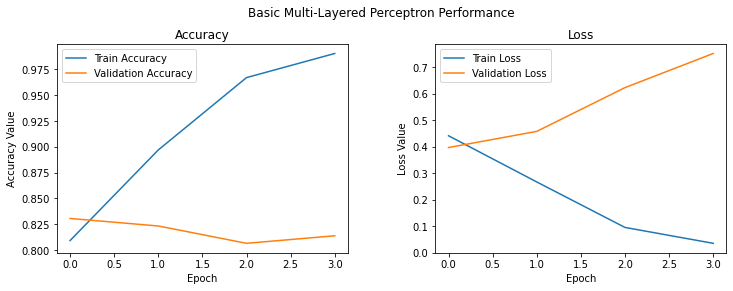

In [0]:
# f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))
f, (ax1, ax3) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic Multi-Layered Perceptron Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(len(train_history.history['loss'])))
ax1.plot(epoch_list, train_history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, train_history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

# ax2.plot(epoch_list, train_history.history['f1_m'], label='Train F1 Score')
# ax2.plot(epoch_list, train_history.history['val_f1_m'], label='Validation F1 Score')
# ax2.set_ylabel('F1 Score Value')
# ax2.set_xlabel('Epoch')
# ax2.set_title('F1 Score')
# l2 = ax2.legend(loc="best")

ax3.plot(epoch_list, train_history.history['loss'], label='Train Loss')
ax3.plot(epoch_list, train_history.history['val_loss'], label='Validation Loss')
ax3.set_ylabel('Loss Value')
ax3.set_xlabel('Epoch')
ax3.set_title('Loss')
l3 = ax3.legend(loc="best")

In [0]:
bert_preds = model.predict(train_input)

print(classification_report(train_labels, bert_preds.round().astype(int)))

              precision    recall  f1-score   support

         0.0       0.87      0.95      0.91      4097
         1.0       0.91      0.79      0.84      2745

    accuracy                           0.88      6842
   macro avg       0.89      0.87      0.87      6842
weighted avg       0.88      0.88      0.88      6842



In [0]:
test_pred = model.predict(test_input)

In [0]:
submission['target'] = test_pred.round().astype(int)

for k in similar_test.keys():
  summation = submission.loc[similar_test[k],:]['target'].sum() + submission.loc[k,:]['target']
  count = len(similar[k]) + 1
  mean = summation/count
  if mean > 0.5:
    submission.loc[k,'target'] = 1
    submission.loc[similar_test[k],'target'] = 1
  else:
    submission.loc[k,'target'] = 0
    submission.loc[similar_test[k],'target'] = 0

submission.to_csv('2_bert_submission.csv', index = False)

**KAGGLE SCORE:** 0.83946

Lastly, we will try and combine the predictions of the BERT model with the two previously strongest models, which produced `lr_pred` and `svc_pred`. The results are not likely to be as strong as the BERT model alone, but it's worth a try.

In [0]:
stack_pred_2 = []

for i in range(len(lr_pred)):
  if (lr_pred[i] + test_pred[i] + svc_pred[i]) >= 2:
    stack_pred_2.append(1)
  else:
    stack_pred_2.append(0)
    

submission['target'] = stack_pred_2

for k in similar_test.keys():
  summation = submission.loc[similar_test[k],:]['target'].sum() + submission.loc[k,:]['target']
  count = len(similar[k]) + 1
  mean = summation/count
  if mean > 0.5:
    submission.loc[k,'target'] = 1
    submission.loc[similar_test[k],'target'] = 1
  else:
    submission.loc[k,'target'] = 0
    submission.loc[similar_test[k],'target'] = 0

submission.to_csv('2_stacked_submission.csv', index = False)

**KAGGLE SCORE:** 0.83231

As expected, the introduction of the two weaker models hindered performance.

# 6. Conclusion

## Reflection

The results I achieved throughout this process were very surprising. After dozens of hours of experimentation, a fragment of which can be seen here, the best results proved to have come from some very simple pre-processing.

<br>

When I initially began modelling, I had not dealt with duplicates and I was using a simple Tfidf Vectorizer. When doing so, my initial baseline results were relatively poor. As a result, many of the iterative cleaning steps improved the model substantially. Many of the cleaning steps were being accepted by the `try_step()` function and my models were improving by rougly 5 percentage points from the baseline throughout the cleaning process. However, they remained in the high-70s.

<br>

However, after taking a closer look at the data and dealing with duplicates and putting Google's universal encoder to use, the baseline models shot up. The stacked model, which achieved 81%+ f1-score on Kaggle, was 3+ percentage points better than the cleaned and optimized non-deep learning models I had trained before.

<br>

Ultimately, of the models scored on Kaggle, BERT proved to be the best, which was to be expected. However, the difference between the BERT results and the result of the stacked baseline is not immense. Though with more time, the results of the BERT model could likely be improved from the ~84% that was achieved, it's not clear that the complexity of the model is warranted given the performance of the simpler models.

## Recommendations

The recommendation for users of the models created above is to opt for the simplicity of the ensembled approach using simple algorithms, such as **logistic regress** and **naive bayes**. Given that performance is quite good if cleaning is done with some amount of diligence, the simpler models are a good option. More complex models, though powerful in their own right, introduce unwarranted overhead and complexity.

## Opportunities for Improvement

Other steps that may have been worthwhile to experiment include dependency parsing and n-grams. However, the reason for not using them is that nature of tweets is that they are not easily cleaned so as to be used effectively alongside a parser. With that said, with more time, the appropriate cleaning could have been done to make those tools effective.

In [0]:
!zip -r /content/file.zip /content

In [0]:
from google.colab import files
files.download("/content")